# Model Exploration
In this section, we will apply different classification models to the data previously analyzed. 

The types of models we are going to test are:
- Support Vector Machine or **SVC**
- Logistical Regression
- Neural Network or **NN**
- Convolutional Neural Network or **CNN**

In [160]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Dataset and Train-Test function
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Classifactions sklearn
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc

# Classification Keras + Tensorflow + Torch
import torch 
import torch.utils
import torch.nn as nn 
import torch.utils.data
import tensorflow as tf
import torch.optim as optim 
import torchvision.models as models
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def plot_roc(y_test, y_scores):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test==1, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test==1, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def print_metrics(y_test, y_pred): 
    print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred)}')
    print(f'\nConfusion-Matrix: \n{confusion_matrix(y_test==1, y_pred)}')
    print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred):.4f}')  
    print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred):.4f}')


def plot_all(y_test, y_scores, y_pred, classes):
    plot_roc(y_test, y_scores)
    plot_confusion_matrix(y_test, y_pred, classes)
    print_metrics(y_test, y_pred)


Esta es la parte del análisis de los diversos tipos de clasificación sobre los que vamos a trabajar. Estos tipos son:
- SVC ( Support Vector Machine )
- LogisticalRegression
- NN ( Neural Network )
- CNN ( Convolutional Neural Network)

Dentro de cada unos de los modelos de clasificación que vamos a utilizar, vamos a realizar 3 métodos para evaluar sus resultados:
- Holdout
- Resubstitution
- Cross-Validation

En el apartado de métricas a utilizar, nos hemos decantado por las siguientes para su uso en todos los modelos:
- Dentro del propio classifiation_report:
  - Precision 
  - Recall
  - F1-Score
- Roc_Auc_Score
- Accuracy_Score

#### <label style='color:red'>Explicación de las métricas</label>

- **Precisión ( Precision )** : Proporción de los Verdaderos Positivos ( TP ) sobre todos los positivos ( TP + FP) 
- **Recall ( Recuperación | Sensibilidad )** : Proporción de los Verdaderos Positivos ( TP ) sobre todos los valores positivos reales ( TP + FN ). Esta métrica es la que nos indica la capacidad del propio clasificador de encontrar la clase positiva.
- **F1-Score** : Es la media armónica entre la precisión y el recall. Se utiliza cuando tenemos un desequilibrio entre las clases de los datos.
- **ROC_AU ( Área bajo la curva ROC )** : Mide la capacidad de un modelo de distinguir entre las clases positivas y negativas variando el umbral de decisión. A mayor valor, mayor capacidad de clasificación tendrá el modelo.
- **Accuracy ( Precisión global )** : Es la proporción de predicciones correctas ( TP + FN ) sobre el total de predicciones ( FP + FN + TP + TN ).

#### <label style='color:red'>Explicación de los 3 métodos de evaluación de modelos</label>
- **Holdout** : 
    - Dividimos el conjunto de datos en (1) Entrenamiento y (2) Testing 
    - Entrenamos el modelo con el conjunto (1) y realizamos pruebas con (2)
    - Es el más común a la hora de entrenar modelo y realizar pruebas en primera instancia
- **Resubstitution** : 
    - Usamos el mismo conjunto para entrenamiento y testing
    - Se calcula el rendimiento usando los mismos datos que fueron usados para el entrenamiento
    - Suele ser una evaluación sobreoptimista del modelo ya que puede estar sobreentrenado al usar los mismos datos para entrenar y para testings
- **Cross-Validation** : 
    - Dividimos el conjunto de datos en (k) subconjuntos de igual tamaño
    - entrenamos el modelo (k) veces usando (k-1) subconjuntos como datos de entrenamiento y el sobrante como subconjunto de testing
    - Es útil cuando tenemos pocos datos y/o queremos una estimación más precisa del rendimiento del modelo.

##### Load Dataset

In [164]:
lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target
X.shape, y.shape

((1456, 50, 37), (1456,))

The shape show us that we have a dataset with 1456 images with a 50x37 pixel resolution

##### Positive-Negative Image

Text(0.5, 1.0, 'Negative class Image')

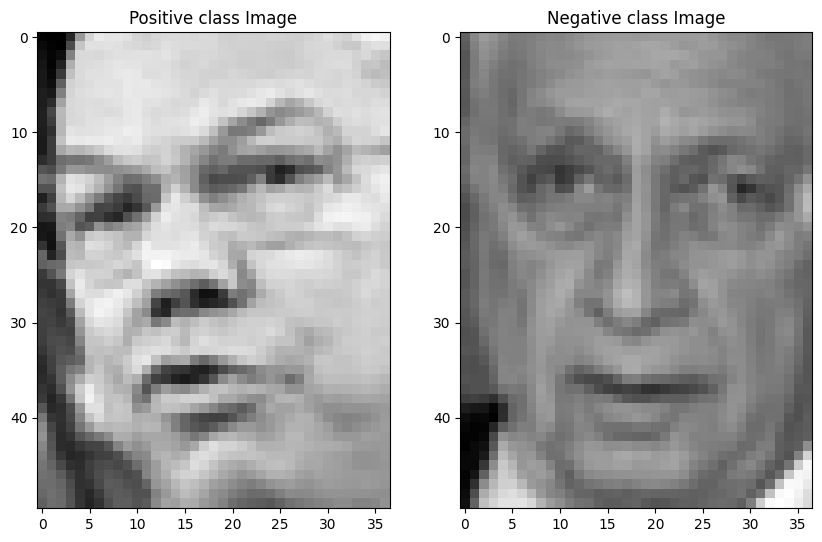

In [137]:
# Plot a positive and negative image for classifications purposes
plt.figure(figsize=(10,10))
# Positive
plt.subplot(1,2,1)
plt.imshow(X[y==1][0], cmap='gray')
plt.title('Positive class Image')
# Negative
plt.subplot(1,2,2)
plt.imshow(X[y==0][0], cmap='gray')
plt.title('Negative class Image')

In [138]:
# This will show us if we are ir [0,1] range or [0, 255]
np.min(X),np.max(X)

(0.0, 1.0)

As we can see, we don't have to normalize the images to [0, 1] range cause we already are in it

In [139]:
# We want to know how many people we have in the dataset to classify
len(np.unique(y))

10

### First dataset implementations

#### Data preprocessing

In [174]:
X_reshape = X.reshape((X.shape[0], -1 )) # Flatten image

labelEncoder = LabelEncoder()
y_encoded = labelEncoder.fit_transform(y)
X_reshape.shape, y_encoded.shape

((1456, 1850), (1456,))

#### Split the dataset

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y_encoded, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 1850), (292, 1850), (1164,), (292,))

#### Classifiers

### SVC ( Support Vector Machines)

#### <label style='color:red'>Explicación del SVC</label>

Los SVM son algoritmos de aprendizaje supervisado utilizados para la clasificación y la regresión. Tienen como objetivo encontrar el mejor hiperplano que separe las principales características del espacio.

Funciona así:
- Selección de Hiperplano : 
    - SVM busca el mejor hiperplano que mejor separa las diferentes clases.
    - El hiperplano óptimo es aquel que maximiza la distancia entre el hiperplano y los puntos de datos más cercanos de cada clase.
- Transformación de características :
    - Si los datos no son linealmente separables en el espacio original, podemos aplicar una transformación no lineal, llevando los datos a una dimensión mayor donde si serán linealmente separables.
- Función pérdida y optimización: 
    - Usa una función de pérdida como la de bisagra ( hinge-loss ), para penalizar las clasificaciones incorrectas y al mismo tiempo maximizar el margen.
    - Se formula un problema de optimización convexa para encontrar el hiperplano que minimiza la función de pérdida y maximiza el margen.

#### Holdout

In [62]:
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

svm_classifier.fit(X_train, (y_train==1))

SVC(kernel='linear', probability=True, random_state=42)

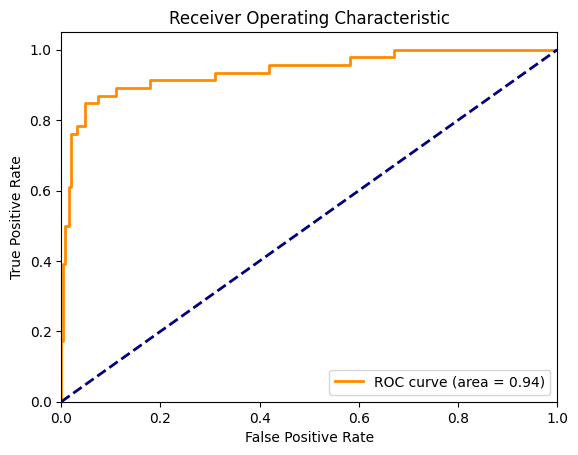

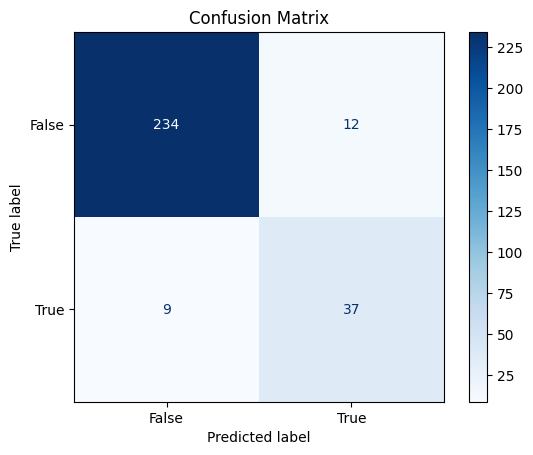

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.96      0.95      0.96       246
        True       0.76      0.80      0.78        46

    accuracy                           0.93       292
   macro avg       0.86      0.88      0.87       292
weighted avg       0.93      0.93      0.93       292


Confusion-Matrix: 
[[234  12]
 [  9  37]]

ROC-AUC-Score: 
0.8778

Accuracy-Score: 
0.9281


In [63]:


y_scores = svm_classifier.predict_proba(X_test)[:,1]
y_pred = svm_classifier.predict(X_test)

plot_all(y_test, y_scores, y_pred, svm_classifier.classes_)


#### <label style='color:red'>Explicación de resultados</label>
- Precision : 
    - Es la proporción de instancias clasificadas como positivas que son verdaderamente positivas.
    - En este caso tenemos que l 94% de las instancias negativas son verdaderamente negativas y el 100% de las positivas son realmente positivas.
- Recall : 
    - Es la proporción de instancias positivas que han sido clasificadas como positivas.
    - En este caso el 100% de las clasificadas como negativas eran verdaderamente negativas mientras que de las positivas, solamente el 64% de las positivas eran verdaderamente positivas
- F1-Score :
    - Media armónica entre precisión y recall.
- Support :
    - Número de casos de entrenamiento de cada clase
- Matriz de confusión :
    - Este clasificador predijo correctamente 246 veces mientras que 17 casos casos 'False' fueron etiquetados como 'True' mientras que 0 instanias 'True' fueron etiquetados como 'False'.
- ROC_AUC score : 
    - En este caso, el 81.52% es un buen valor que nos indica el rendimiento del modelo para distinguir entre clases.
- Accuracy score: 
    - En este caso, como tenemos un 94.17% nos indica que de todas las muestras, más del 90% han sido clasificadas correctamente

#### Resubstitution

In [128]:
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

svm_classifier.fit(X_train, (y_train==1))

SVC(kernel='linear', probability=True, random_state=42)

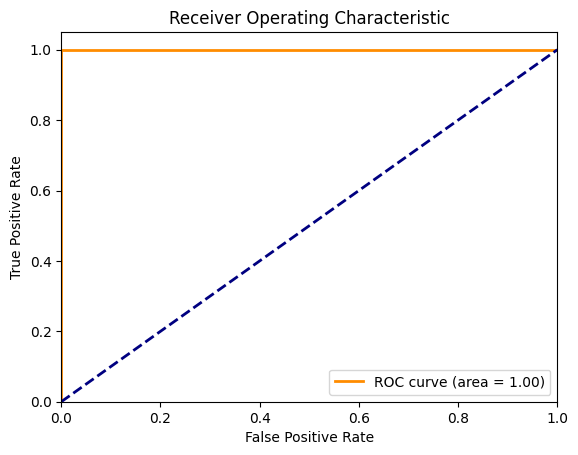

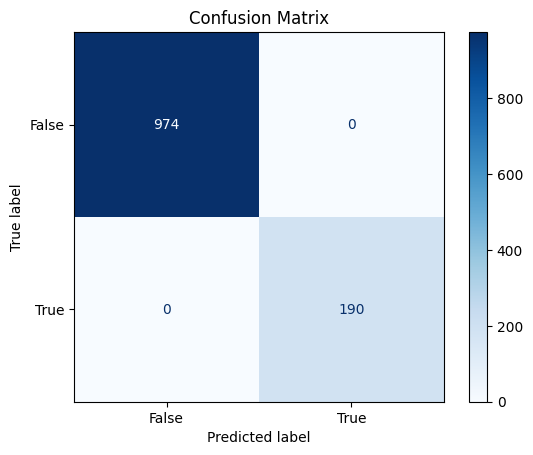

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       974
        True       1.00      1.00      1.00       190

    accuracy                           1.00      1164
   macro avg       1.00      1.00      1.00      1164
weighted avg       1.00      1.00      1.00      1164


Confusion-Matrix: 
[[974   0]
 [  0 190]]

ROC-AUC-Score: 
1.0000

Accuracy-Score: 
1.0000


In [130]:


y_scores = svm_classifier.predict_proba(X_train)[:,1]
y_pred = svm_classifier.predict(X_train)

plot_all(y_train, y_scores, y_pred, svm_classifier.classes_)


#### Cross-Validation

In [146]:
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

scores = cross_val_score(svm_classifier, X_train, y_train==1, cv=5)

In [149]:
np.max(scores), np.min(scores), np.average(scores), np.mean(scores)

(0.9699570815450643,
 0.9098712446351931,
 0.9372946573923338,
 0.9372946573923338)

### Logistic Regression 

#### <label style='color:red'>Explicación de la Regresión Logistica</label>

La regresion Logística es un algoritmo de aprenizaje supervisado utilizado principalmente para la clasificación binaria, aunque puede extenderse a la clasificación multiclase con algoritmos como regresión multinominal.

Funciona así:

- Modelo matemático : 
    - Utiliza la función logística ( sigmoide ) para modelar la probabilidad de que una instancia pertenezca a una  clase en particular
    - Esta función transforma cualquier valor al rango [0,1]
- Entrenamiento del modelo : 
    - Durante el entrenamiento, este ajusta el los parámetros del modelo para maximizar la verosimilitud de los datos obsevador.
    - Esto implica ajustar los parámetros del modelo de manera que la probabilidad de observar las etiquetas de clase reales dados los datos de entrada sea máxima
- Función de costo : 
    - La función de costo más comunmente utilizada es la 'binary cross-entropy'
    - Esta función penaliza las predicciones incorrectas de manera proporcional a la diferencia entre la probabilidad predicha y la verdadera
- Predicción : 
    - Una vez entrenado el modelo, se utiliza para predecir la probabilidad de que una nueva instancia pertenezca a cada clases
    - Si la probabilidad predicha es mayor que 0.5, entonces la instancia se clasifica como perteneciente a la clase positiva

In [157]:
logisticClassifier = LogisticRegression()

logisticClassifier.fit(X_train, (y_train==1))

LogisticRegression()

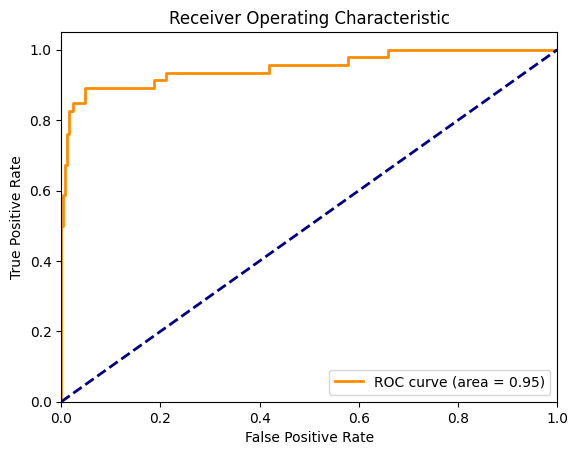

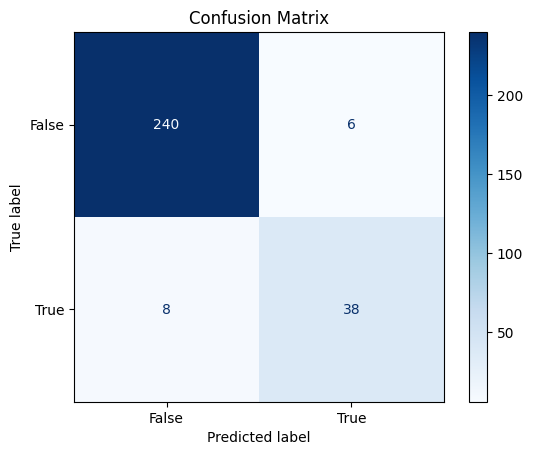

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       246
        True       0.86      0.83      0.84        46

    accuracy                           0.95       292
   macro avg       0.92      0.90      0.91       292
weighted avg       0.95      0.95      0.95       292


Confusion-Matrix: 
[[240   6]
 [  8  38]]

ROC-AUC-Score: 
0.9008

Accuracy-Score: 
0.9521


In [158]:
y_pred = logisticClassifier.predict(X_test)
y_scores = logisticClassifier.predict_proba(X_test)[:,1]

plot_all(y_test, y_scores, y_pred, logisticClassifier.classes_)

#### <label style='color:red'>Explicación de resultados</label>
- Precision : 
    - Es la proporción de instancias clasificadas como positivas que son verdaderamente positivas.
    - En este caso tenemos que l 97% de las instancias negativas son verdaderamente negativas y el 86% de las positivas son realmente positivas.
- Recall : 
    - Es la proporción de instancias positivas que han sido clasificadas como positivas.
    - En este caso el 98% de las clasificadas como negativas eran verdaderamente negativas mientras que de las positivas, el 83% de las positivas eran verdaderamente positivas
- F1-Score :
    - Media armónica entre precisión y recall.
- Support :
    - Número de casos de entrenamiento de cada clase
- Matriz de confusión :
    - En este caso, la clase False se predijo correctamente en 240 casos, mientras que 6 instancias verdaderamente False se clasificaron incorrectamente como True. Para la clase True, 38 instancias verdaderamente True se clasificaron correctamente, mientras que 8 instancias verdaderamente False se clasificaron incorrectamente como False
- ROC_AUC score : 
    - En este caso, el 90.08% es un buen valor que nos indica el rendimiento del modelo para distinguir entre clases.
- Accuracy score: 
    - En este caso, como tenemos un 95.20% nos indica que de todas las muestras, más del 95% han sido clasificadas correctamente

#### Holdout

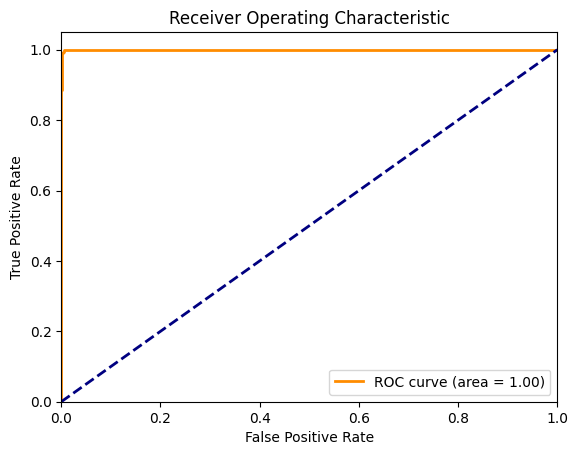

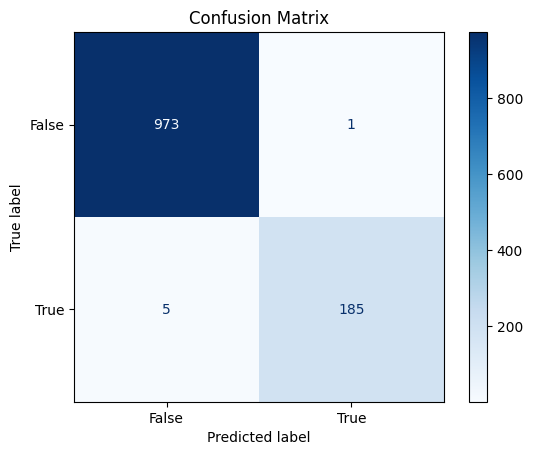

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       974
        True       0.99      0.97      0.98       190

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164


Confusion-Matrix: 
[[973   1]
 [  5 185]]

ROC-AUC-Score: 
0.9863

Accuracy-Score: 
0.9948


In [159]:
logisticClassifier = LogisticRegression()

logisticClassifier.fit(X_train, (y_train==1))

y_pred = logisticClassifier.predict(X_train)
y_scores = logisticClassifier.predict_proba(X_train)[:,1]

plot_all(y_train, y_scores, y_pred, logisticClassifier.classes_)

#### Cross-Validation

In [176]:
logisticClassifier = LogisticRegression()

scores = cross_val_score(logisticClassifier, X_reshape, y==1, cv=5)

y_pred = logisticClassifier.predict(X_reshape)
y_scores = logisticClassifier.predict_proba(X_reshape)[:,1]

plot_all(y_test, y_scores, y_pred, logisticClassifier.classes_)

NameError: name 'X_res' is not defined

### Neural Network

#### <label style='color:red'>Explicación de Red neuronal</label>

Es un modelo computacional inspirado en el funcionamiento del cerebro humano. Compuesta por nodos interconectados llamados neuronas, que trabajarn en conjunto par realizar tareas de aprendizaje automático, como clasificación, regresión o reconocimiento de patrones entre muchas.

- Neuronas :
    - Son las unidades básicas de procesamiento en una red neuronal. Cada neurona recibe entradas, realiza operaciones y manda una salida
    - Cada neurona tiene un conjunto de pesos asociados que determinan la importancia de las entradas en el cálculo de la salida
    - Las neuronas tiene una función de activación que deciden si deben mandar una señal de salida o no
- Capas : 
    - Las neuronas se organizan en capas en una red neuronal. La red puede tener más o menos capas intermedias, llamadas capas ocultas, además de una capa de entrada y salida.
    - En la capa de entrada, las neuronas reciben los datos de entrada y, en la de salida las neuronas producen la salida final de la red. En las capas intermedias la red procesa y transforma los datos de la entrada.
- Conexiones : 
    - Cada neurona está conectada a todas las neuronas de la siguiente capa. Estas conexiones están asociadas con pesos que determinan la fuerza de conexión entre neuronas
    - Durante el entrenamiento, los pesos se actualizan por algoritmos de optimización para minimizar la función de pérdida.
- Feedward y Retropropagación :
    - En la etapa de Feedward, las entradas se propagan a traves de las capas hasta la salida, provocando una predicción
    - En la capa de retropropagación, el error entre las predicciones del modelo y y las etiquetas verdadeas se propagan hacia atrás a través de la red. Los pesos de las conexiones se ajustan usando algoritmos como el descenso por gradiente

In [69]:
# Aqui pasamos a one-hot encoding las etiquetas para poder diferenciar las 10 clases de las im'agenes
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### <label style='color:red'>Explicación del porqué de la estructura de la red</label>


In [94]:
neuralModelo = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(48, activation='relu'),
    Dense(10, activation='softmax')
])
neuralModelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neuralModelo.summary()

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │       118,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,234 (493.10 KB)

 Trainable params: 126,234 (493.10 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
history = neuralModelo.fit(X_train, (y_train), epochs=1000, batch_size=64, validation_split=.2)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2932 - loss: 2.0944 - val_accuracy: 0.3820 - val_loss: 1.9262
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3586 - loss: 1.9710 - val_accuracy: 0.3863 - val_loss: 1.8919
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3696 - loss: 1.9006 - val_accuracy: 0.3948 - val_loss: 1.8465
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3702 - loss: 1.9105 - val_accuracy: 0.4077 - val_loss: 1.8215
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3836 - loss: 1.8554 - val_accuracy: 0.4335 - val_loss: 1.7500
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4190 - loss: 1.7540 - val_accuracy: 0.4807 - val_loss: 1.6650
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4374 - loss: 1.6908 - val_accuracy: 0.4549 - val_loss: 1.6641
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4721 - loss: 1.6103 - val_accuracy: 0

In [96]:
y_pred_neural = neuralModelo.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_neural)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_neural):.4f}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_neural):.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Results:
Classification-Report:
              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.92      0.72      0.80        46
           2       1.00      0.27      0.42        26
           3       0.99      0.66      0.79       106
           4       1.00      0.27      0.43        11
           5       0.86      0.35      0.50        17
           6       1.00      0.11      0.20         9
           7       0.00      0.00      0.00        18
           8       1.00      0.17      0.29        12
           9       1.00      0.12      0.22        33

   micro avg       0.96      0.43      0.60       292
   macro avg       0.88      0.27      0.38       292
weighted avg       0.91      0.43      0.55       292
 samples avg       0.43      0.43      0.43       292


ROC-AUC-Score: 
0.6361

Accuracy-Score: 
0.4349


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<label style='color:red'>Explicación de los resultados</label>

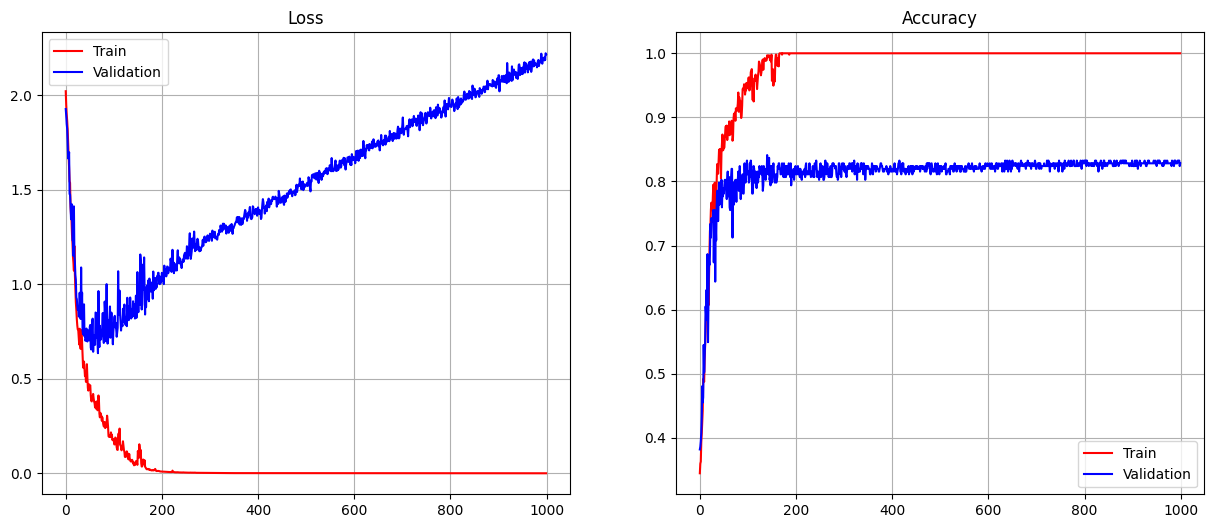

In [97]:
plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train', c='red')
plt.plot(history.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train', c='red')
plt.plot(history.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

<label style='color:red'>Explicación de la gráfica</label>

In [98]:
acierto, fallo = 0,0

for a,b in zip(y_pred_neural, y_test):
    if(b[1]==1):
        #7print(a, '\t', b)
        if (a[1]==1):
            acierto +=1
        else:
            fallo += 1
print(f"Acierto (%total) = {acierto} ({acierto+fallo}) -->  {acierto/(acierto+fallo)*100:.4f}%")

Acierto (%total) = 33 (46) -->  71.7391%


### CNN

#### <label style='color:red'>Explicación de una red convolucional</label>

Es un tipo de red neuronal diseñada específicamente para procesar datos estructurados de forma cuadrática, como imágenes, 

- Convolución : 
    - Es la operación central de las CNN. Consiste en deslizar un pequeño filtro sobre la imagen de entrada y realizar una multiplicación elemento por elemento entre el filtro y la región de la imagen que está cubriendo. Luego sumamos estos productos.
    - Esta operación ayuda a la extracción de características locales de la imagen, como bordes, texturas y patrones en diferentes niveles de abstracción.
- Capas Convolucionales : 
    - Una CNN está compuesta principalmente por capas de convolución, que aplican múltiples filtros para extraer diferentes características de la imagen de entrada. 
    - Cada filtro produce un mapa de características  que resalta una específica de la imagen, como patrones, bordes o texturas.
-  Submuestreo ( Pooling ) : 
    - Después de la capa de convolución, podemos agregar capas de pooling para reducir la dimensionalidad de los mapas de características.
    - La operación de pooling reduce la dimensionalidad al tomar la operación ( max si maxpooling, min ... minpoolin, avg ... avgpoolin ) y aplicarla sobre una fracción del mapa de caracerísticas del mismo modo en que reazlizábamos la convolución
- Caaps completamente conectadas ( Dense ) :
    - Después de varias (o no) capas de convolución y pooling, la red puede tener una o varias capas Densas para realizar la clasificación final.
    - Estas toman las características extraídas por las capas anteriores y las combinan para producir una salida que presente las clases.
- Funciones de activación : 
    - En cada capa de la CNN se aplica una función de activación (normalmente la ReLu) después de la convolución y la operación de pooling para así introducir no linealidad en la red y permitir las representaciones complejas entre las características 

In [99]:
# Vamos a volver a cargar los datos para pasarlo a los tensores necesarios parar que funcione el algoritmo

lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target


In [100]:
# aplicamos un encoder sobre los labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [101]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 50, 37), (292, 50, 37), (1164,), (292,))

In [102]:
# Agregamos una dimension adicional para el canal de color (estamos originalmente en una escala de grises)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape, X_test.shape

((1164, 50, 37, 1), (292, 50, 37, 1))

In [103]:
# Cambiamos a one hot enconding las etiquetas
y_train =   to_categorical(y_train)
y_test =    to_categorical(y_test)

<label style='color:red'>Explicación del porqué de la forma de la CNN</label>

In [120]:
# Definimos el modelo
#
num_epochs = 1000
#
modeloCNN = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=( X_train.shape[1], X_train.shape[2], 1) ),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
    ])
#
modeloCNN.summary()
#
modeloCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#
earlyStop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
historyCNN = modeloCNN.fit(X_train, y_train==1, epochs=num_epochs, batch_size=32, validation_split=.25)

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 35, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 26112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │       835,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,642 (3.20 MB)

 Trainable params: 837,642 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2172 - loss: 0.4663 - val_accuracy: 0.3814 - val_loss: 0.3013
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3187 - loss: 0.3049 - val_accuracy: 0.3814 - val_loss: 0.2830
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3613 - loss: 0.2871 - val_accuracy: 0.3814 - val_loss: 0.2755
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3772 - loss: 0.2723 - val_accuracy: 0.4296 - val_loss: 0.2600
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3817 - loss: 0.2592 - val_accuracy: 0.5086 - val_loss: 0.2437
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4847 - loss: 0.2348 - val_accuracy: 0.5258 - val_loss: 0.2270
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5570 - loss: 0.2231 - val_accuracy: 0.4811 - val_loss: 0.2218
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5142 - loss: 0.2154 - val_accu

In [121]:
y_pred_CNN = modeloCNN.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_CNN)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_CNN):.4f}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_CNN):.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Results:
Classification-Report:
              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.97      0.83      0.89        46
           2       1.00      0.46      0.63        26
           3       0.96      0.86      0.91       106
           4       0.71      0.45      0.56        11
           5       1.00      0.47      0.64        17
           6       1.00      0.56      0.71         9
           7       1.00      0.33      0.50        18
           8       1.00      0.67      0.80        12
           9       0.95      0.61      0.74        33

   micro avg       0.96      0.68      0.80       292
   macro avg       0.95      0.57      0.70       292
weighted avg       0.96      0.68      0.78       292
 samples avg       0.68      0.68      0.68       292


ROC-AUC-Score: 
0.7846

Accuracy-Score: 
0.6849


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<label style='color:red'>Explicación de resultados</label>

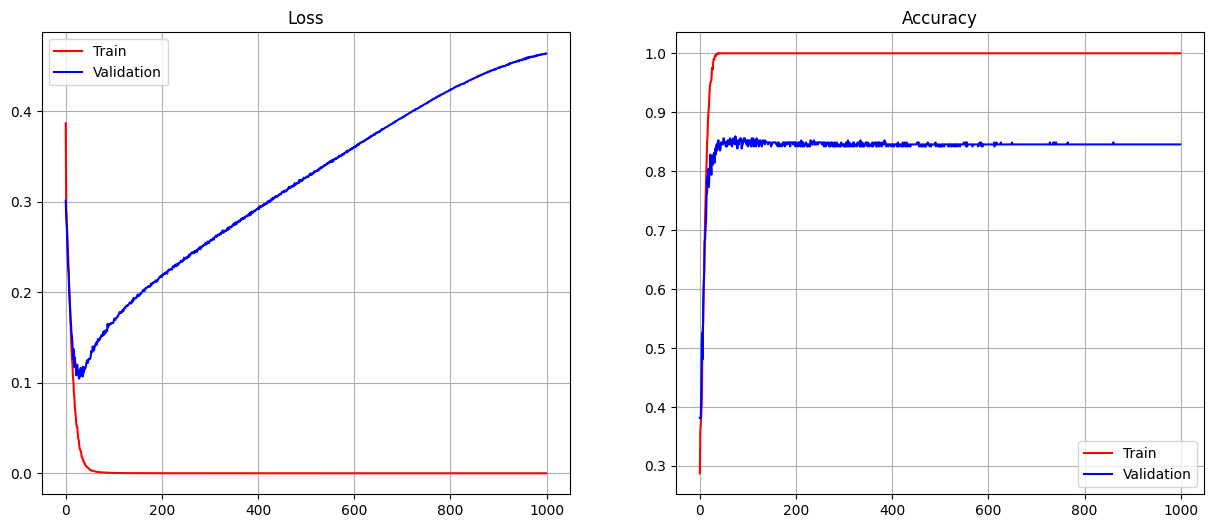

In [122]:

plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(historyCNN.history['loss'], label='Train', c='red')
plt.plot(historyCNN.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(historyCNN.history['accuracy'], label='Train', c='red')
plt.plot(historyCNN.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

<label style='color:red'>Explicación de la gráfica</label>

In [123]:
acierto, fallo = 0, 0

for a,b in zip(y_pred_CNN, y_test):
    if(b[1]==1):
        #7print(a, '\t', b)
        if (a[1]==1):
            acierto +=1
        else:
            fallo += 1
print(f"Aciertos | Fallos (%total) = {acierto} | {fallo} ({acierto/(acierto+fallo)*100:.4f}%)")

Aciertos | Fallos (%total) = 38 | 8 (82.6087%)


# Model evaluation

In this section, we will discuss the results obtained with each model using the following methods:
- Resubstitution
- Holdout
- Cross-Validation